In [7]:
import os
import git
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import date, datetime, timedelta
import matplotlib.dates as mdates
import plotly.graph_objects as go
import glob
from itertools import product

In [8]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    return git_repo.working_dir

In [9]:
# Define a function to align and merge temp and lux dataframes
def align_and_merge_temp_lux(df_temp, df_lux):
    # Convert DATE and TIME to Datetime timestamps
    df_temp['DATETIME'] = pd.to_datetime(df_temp['DATE'].astype(str) + ' ' + df_temp['TIME'].astype(str))
    df_lux['DATETIME'] = pd.to_datetime(df_lux['DATE'].astype(str) + ' ' + df_lux['TIME'].astype(str))

    # Restrict both dataframes to the same datetime range (as sometimes one recording device was on while the other was off)
    start_time_temp = df_temp['DATETIME'].min()
    end_time_temp = df_temp['DATETIME'].max()
    df_lux_restricted = df_lux[(df_lux['DATETIME'] >= start_time_temp) & (df_lux['DATETIME'] <= end_time_temp)]

    start_time_lux = df_lux_restricted['DATETIME'].min()
    end_time_lux = df_lux_restricted['DATETIME'].max()
    df_temp_restricted = df_temp[(df_temp['DATETIME'] >= start_time_lux) & (df_temp['DATETIME'] <= end_time_lux)]

    # Merge the dataframes on the nearest datetime. The tolerance Timedelta is 5 minutes because recording devices collected 1 datapoint every 10 minutes.
    df_merged = pd.merge_asof(df_temp_restricted.sort_values('DATETIME'),
                              df_lux_restricted.sort_values('DATETIME'),
                              on='DATETIME',
                              direction='nearest',
                              tolerance=pd.Timedelta('5min'))

    # Select relevant columns ('VALUE' is the luxmeter recording in lux)
    df_merged = df_merged[['DATETIME', 'T1', 'T2', 'T3', 'T4', 'VALUE']]
    
    df_merged['VALUE'] = (df_merged['VALUE'].astype(int))*0.0079 # Convert to W/m2 by using conversion factor for sunlight: 0.0079W/m2/lux

    df_merged['T2_filt'] = df_merged['T2'].rolling(window=3, center=True).median() # Apply a filter to smooth out Main tank temperature
    
    return df_merged # The function returns the merged temp and lux dataframes, with a smoothed main tank temperature and lux converted to W/m2


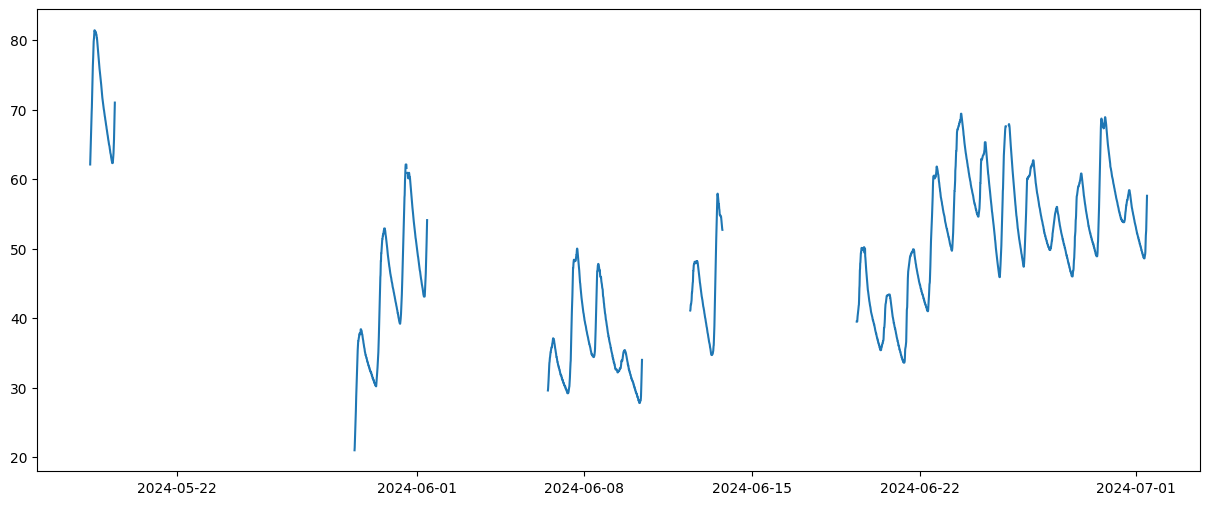

In [11]:
# Initialize an empty list to store merged dataframes
df_list = []

temp_col = ['DATE','TIME','T1','T2','T3','T4'] # column names
temp_use = list(np.arange(len(temp_col)))

lux_col = ['PLACE','DATE','TIME','VALUE','UNIT'] # column names
lux_use = list(np.arange(len(lux_col)))

# Process and merge each temperature file with the lux file
temp_files = glob.glob(os.path.join(get_git_root(os.getcwd()), 'data', 'raw_data', 'temperature', 'train_data', '*.csv'))

for temp_file in temp_files:
    # Load the temperature data
    df_temp = pd.read_csv(temp_file, header=None, skiprows=1, names=temp_col, na_filter=True, na_values=-200, usecols=temp_use)

    # Load the latest lux data (which contains all previous lux data as well)
    df_lux = pd.read_csv(os.path.join(get_git_root(os.getcwd()), 'data', 'raw_data', 'light', 'LUX_07_01.csv'),header=None,skiprows=1,names=lux_col,na_filter=True,na_values=-200,usecols=lux_use)
    df_lux = df_lux[df_lux['DATE'] != 'Date'] # Get rid of the logging restarts
    df_lux = df_lux[df_lux['UNIT'] != 'Ft cd   '] # Get rid of false data
    
    # Convert T3 (biodigester temperature serving as proxy for ambient temperatures) to numeric, coercing errors
    df_temp['T3'] = pd.to_numeric(df_temp['T3'], errors='coerce')
    
    # Align and merge with the lux data
    df_merged = align_and_merge_temp_lux(df_temp, df_lux)
    
    # Append the merged dataframe to the list
    df_list.append(df_merged)

# Concatenate all merged dataframes into one big dataframe
final_df = pd.concat(df_list, ignore_index=True)

# Place them in chronological order
final_df = final_df.sort_values(by='DATETIME')

# Set the DATETIME column as the index
final_df.set_index('DATETIME', inplace=True)

# On may 30th (temperature filename '05_29-31.csv', the main tank thermocouple experiences a malfunction which makes it underestimate temperature by 6°C for 3 hours. Manually adjust
dip_start_date = '2024-05-30 12:32'
dip_end_date = '2024-05-30 15:33'
dip_start_date_dt = datetime.strptime(dip_start_date, '%Y-%m-%d %H:%M')
dip_end_date_dt = datetime.strptime(dip_end_date, '%Y-%m-%d %H:%M')
# 2. Add 6 degrees to this portion of the data
final_df.loc[dip_start_date_dt:dip_end_date_dt, 'T2_filt'] += 6

#Plot the final merged and adjusted main tank temperature data
plt.figure(figsize=(15, 6))
plt.plot(final_df.index, final_df["T2_filt"], label='Main Tank Temperature')
plt.show()


In [7]:
# Model Fitting: Using gridsearch, we find the optimal U and k which can simulate the recorded data as accurately as possible

U_values = np.linspace(2, 6, 30)  # Search range for U (which in reality = U * Area for 150L tank)
k_values = np.linspace(0.8, 1.2, 30)  # Search range for k

# Standard Variables which were used on the system in practice
Main_tank_cap = 150 # Main tank capacity in litres
#A = (2 + Main_tank_cap*8.1/150) / 10.1
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100) #This is the heat exchange area of the cylindrical main tank. See annex 2 of the report
#air_temp = 20  # Default value, can be adjusted or derived from data

#Use the mean value for T3 as a proxy for air temperature
if final_df['T3'].notna().sum() > 0:  # Check if there are any non-NaN values
    air_temp = final_df['T3'].mean()
else:
    air_temp = 20  # Default value

# Store the results
best_error = float('inf')
best_params = {'U': None, 'k': None}

# Perform the grid search
for U, k in product(U_values, k_values):
    MT_sim = pd.Series([0.0] * len(final_df['T2_filt']), index=final_df.index)
    MT_sim.iloc[0] = final_df['T2_filt'].iloc[1] # Initialise MT_sim with the first correct datapoint
    for i in range(len(final_df['T2_filt'])-1):
        if pd.isna(final_df['VALUE'].iloc[i]):
            MT_sim.iloc[i+1] = MT_sim.iloc[i] # If light data is missing, reallocate the same temperature to the next datapoint
        elif final_df.index[i+1]-final_df.index[i] > timedelta(minutes=11):
            MT_sim.iloc[i+1] = final_df['T2_filt'].iloc[i+2] # If there is more than 11 minutes between 2 recorded sets, reinitialise MT_sim with the correct datapoint
        else: # Else calculate the next MT_sim datapoint using 
            MT_sim.iloc[i+1] = (MT_sim.iloc[i] + 
                           k * final_df['VALUE'].iloc[i] * (0.1044 * Main_tank_cap / 10) * 600 / (4184 * Main_tank_cap) - 
                           U * A * (MT_sim.iloc[i] - air_temp) * 600 / (4184 * Main_tank_cap))

    MT_sim.index = final_df.index

    # Align the DataFrames
    MT_sim_aligned, final_df_aligned = MT_sim.align(final_df, join='outer')
    combined_df = pd.concat([MT_sim_aligned, final_df_aligned], axis=1).dropna()
    combined_df.rename(columns={combined_df.columns[0]: 'MT_sim'}, inplace=True)

    # Calculate the root mean squared error
    error = ((((combined_df['T2_filt'] - combined_df['MT_sim'])**2).sum())/len(combined_df['MT_sim']))**0.5

    # Check if this is the best error so far
    if error < best_error:
        best_error = error
        best_params = {'U': U, 'k': k}

# Print the best parameters and the corresponding error
print(f"Best Parameters: U = {best_params['U']}, k = {best_params['k']}")
print(f"Minimum Error: {best_error}")

Best Parameters: U = 2.413793103448276, k = 0.993103448275862
Minimum Error: 3.928346238720175


In [31]:
# Simulate the 150L SWH with the best parameters
U = 2.413793103448276
k= 0.993103448275862

Main_tank_cap = 150
A = (0.2**2)*3.1415*2 + (0.2*2*3.1415)*(Main_tank_cap*0.81/100) #This is the heat exchange area of the cylindrical main tank. See annex 2 of the report

#Use the mean value for T3 as a proxy for air temperature
if final_df['T3'].notna().sum() > 0: 
    air_temp = final_df['T3'].mean()
else:
    air_temp = 20  # Default value

# Initialisation
MT_sim = pd.Series([0.0] * len(final_df['T2_filt']), index=final_df.index)
MT_sim.iloc[0] = final_df['T2_filt'].iloc[1]

#See last kernel for explanations
for i in range(len(final_df['T2_filt'])-1):
    if pd.isna(final_df['VALUE'].iloc[i]):
        MT_sim.iloc[i+1] = MT_sim.iloc[i]
    elif final_df.index[i+1]-final_df.index[i] > timedelta(minutes=11):
        MT_sim.iloc[i+1] = final_df['T2_filt'].iloc[i+2] 
    else: #Heat gain and loss equation with optimised parameters U and k
        MT_sim.iloc[i+1] = MT_sim.iloc[i] + k*final_df['VALUE'].iloc[i]*(0.1044*Main_tank_cap/10) * 600 / (4184 * Main_tank_cap) - U*A*(MT_sim.iloc[i] - air_temp)*600/(4184*Main_tank_cap)

MT_sim.index=final_df.index

# Align the DataFrames to make sure they both have the same index and NaN values
MT_sim_aligned, final_df_aligned = MT_sim.align(final_df, join='outer')
# Combine the DataFrames and drop rows where any NaN values exist
combined_df = pd.concat([MT_sim_aligned, final_df_aligned], axis=1).dropna()
combined_df.rename(columns={combined_df.columns[0]: 'MT_sim'}, inplace=True)

# Pick which timeframe to plot
plot_start_date = '2024-05-18'
plot_end_date = '2024-07-31'
# Cut to chosen timeframe
combined_df_cut = combined_df.loc[(combined_df.index >= plot_start_date) & (combined_df.index <= plot_end_date)]

#Objective function. However this error is counterintuitive and not THAT representative since we intitialise data back to the real point at every data skip
error = ((((combined_df['T2_filt'] - combined_df['MT_sim'])**2).sum())/len(combined_df['MT_sim']))**0.5
print(error)

3.928346238720175


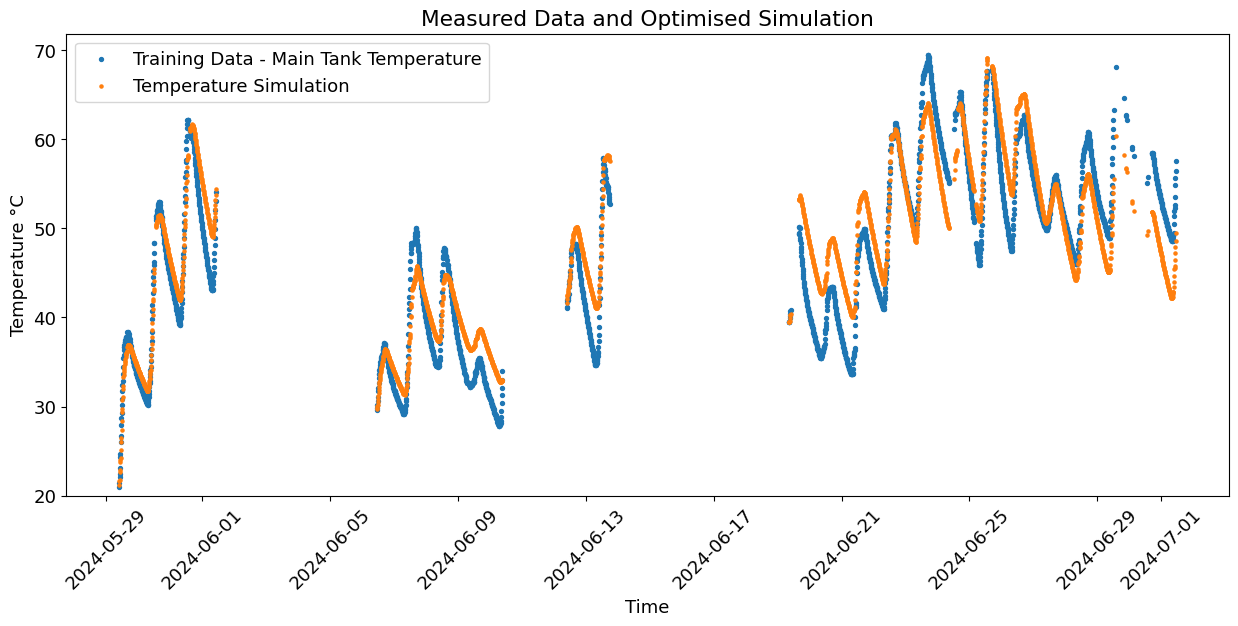

In [33]:
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(15, 6))

# Plot the temperatures from recorded main tank data
plt.scatter(combined_df_cut.index, combined_df_cut['T2_filt'], label='Training Data - Main Tank Temperature', s=8)

# Plot the temperatures from Main Tank temperature simulation
plt.scatter(combined_df_cut.index, combined_df_cut['MT_sim'], label='Temperature Simulation', s=5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Temperature °C')
plt.title('Measured Data and Optimised Simulation')

# Set the y-axis limits to ensure the minimum is 20 degrees
plt.ylim(20, plt.ylim()[1])

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.show()